# Lab 6
Team: <br></br>
Mitchell Morrison <br></br>
Kyle Kolodziej <br></br>
Brian Pattison <br></br>
Sam Yassien <br></br>

## Overview of Data Set
Our dataset from AffectNet (http://mohammadmahoor.com/affectnet/, which can also be found with the PDF uploaded in this directory) is intended to be used for image emotion prediction. The dataset contains 291,651 images. The data set has 8 different image labels: Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, and Contempt. Our data set is imbalanced with some of the labels having a lot more images than other labels. For example, there are 134,915 images that are classified as Happy while there are only 4,250 images that are classified as Contempt. 

## Business Case and Measurement of Performance
Looking at out business case, we believe a model to predict the emotion from an image would be uesful as a program for Autisistic childre. This program would help them develop in identifying people's emotions. However, there are a lot of different image labels that may be hard to distinguish between. With this is mind, we believe it would be beneficial to just look at classifying images that are Neutral, Happy, Sad, and Angry. We picked these 4 categories as we feel that these 4 emotions would be very useful for a user that our business case is geared towards. Also, we believe that it would be better to have a model that has a higher accuracy with predicting a smaller amount of labels rather than a lower accuracy and predicting all of the labels. We believe that a child using this program would not find the model as useful if they are getting a low accuracy in classifying images and, thus, would not be able to correctly gauge another person's emotions.

We will use accuracy to measure the performance of our model. A typical user would be equally as interested in predicting all 4 of the classes that we are using as emotions to predict. Thus, accuracy serves as a good measurement tool for our model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os
import glob
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test, first, sec, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(first + " : " + str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(sec + " : " + str(acc_mlp))

Below, we are getting the images from the data set. Can set the number of images that the model will get or just comment out and let it grab all the images

In [3]:
def getAndResizeImages(file_path) :
    gray = []
    color = []
    imageNumber = []
    for file in os.listdir(file_path) :
        path = file_path + '/' + file
        fileNum = file.replace('.jpg', '')
        im = Image.open(path)
        im = im.resize((50, 50))
        color.append(np.array(im))
        im = im.convert("L")
        gray.append(np.array(im))
        imageNumber.append(str(fileNum))
        if len(gray) > 50000:
            break
    return gray, color, imageNumber


folderPathImage = "../../train_set/train_set/images"
resizedImages, colored, imageNum = getAndResizeImages(folderPathImage)


In [4]:
print(len(resizedImages), "total images")

50001 total images


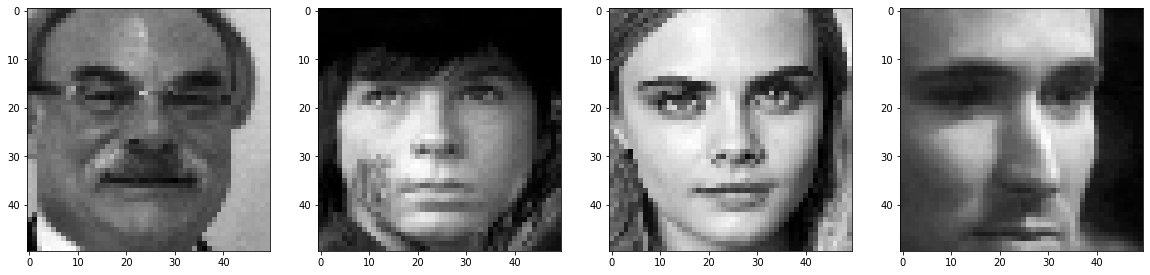

In [5]:
# Let's look at 4 of the images
plt.figure(figsize=(20,20))
for i in range(4):
    img=resizedImages[i]
    ax=plt.subplot(1,4,i+1)
    plt.imshow(img,cmap="gray")

In [6]:
# Going to grab the image labels that correspond to the image
def getImageLabel(file_path,imageNum) :
    labels = []
    for num in imageNum:
        path = file_path + num + "_exp.npy"
        data = np.load(path)
        labels.append(float(data))
    print(len(labels))
    return labels

folderPathAnnotation = "../../train_set/train_set/annotations/"

labels = getImageLabel(folderPathAnnotation, imageNum)

50001


In [7]:
pd.unique(labels)

array([1., 0., 6., 3., 4., 7., 2., 5.])

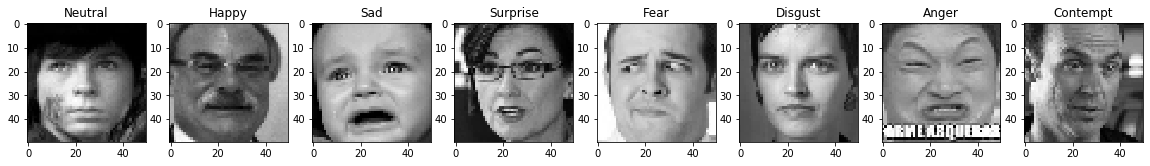

In [8]:
# Print out an image from each type
types = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
plt.figure(figsize=(20,20))
for i in range(8):
    index = labels.index(i)
    img=resizedImages[index]
    ax=plt.subplot(1,8,i+1)
    plt.title(types[i])
    plt.imshow(img,cmap="gray")

In [9]:
from ipywidgets import widgets  # make this interactive!

widgets.interact(lambda x: print(x),x=(0,7,1))

interactive(children=(IntSlider(value=3, description='x', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(x)>

In [10]:
# Have a widget that will show the image and emotion label
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    plt.figure(figsize=(15,7))
    plt.imshow(resizedImages[idx_to_reconstruct],cmap="gray")
    plt.title(types[int(labels[idx_to_reconstruct])])
    plt.grid(False)
    
    
n_samples = len(labels)   
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

interactive(children=(IntSlider(value=25000, description='idx_to_reconstruct', max=50000), Output()), _dom_cla…

<function __main__.plt_reconstruct(idx_to_reconstruct)>

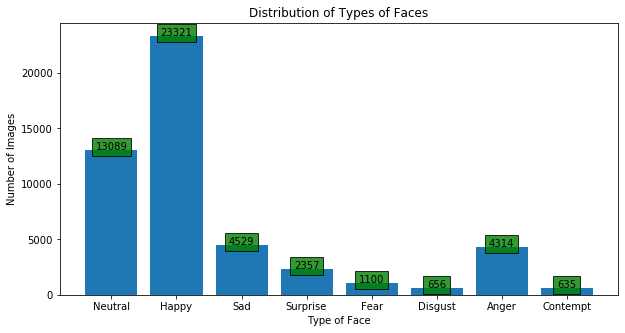

In [11]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center',
                 Bbox = dict(facecolor = 'green', alpha =.8))
y_pos = np.arange(len(types))
labelCount = []
plt.figure(figsize=(10,5))
for i in range(8):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append(labels.count(i))
plt.bar(types, labelCount)
addlabels(types, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

In [15]:
# Will now reduce the labels down to just Neutral, Happy, Sad, and Angry
def createDataset(labels, resizedImages):
    reducedImgs = []
    reducedLabels = []
    labelQuantities = [0, 0, 0, 0]
    for label, img in zip(labels,resizedImages) :
        if label == 0 and labelQuantities[0] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[0] = labelQuantities[0] + 1
        if label == 1 and labelQuantities[1] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[1] = labelQuantities[1] + 1
        if label == 2 and labelQuantities[2] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(label))
                labelQuantities[2] = labelQuantities[2] + 1
        if label == 6 and labelQuantities[3] < 4000:
                reducedImgs.append(img)
                reducedLabels.append(int(3))
                labelQuantities[3] = labelQuantities[3] + 1
    return reducedImgs, reducedLabels, labelQuantities
reducedImgs, reducedLabels, labelQuantities = createDataset(labels, resizedImages)
reducedImgsColor, reducedLabels, labelQuantities = createDataset(labels, colored)

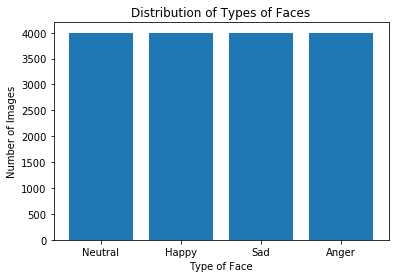

In [16]:
newTypes = ['Neutral', 'Happy', 'Sad', 'Anger']
plt.bar(newTypes, labelQuantities)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

## Train/Test Split

We are going to use a Stratified Shuffle Split with the number of splits as 1 and the test size as 0.2. We want to keep the training and testing sets balanced as each emotion was equally important to predict, so we are using the stratified shuffle split. We decided we only need 1 split and a training/test split of 80/20.

One approach that we thought would be smart is to use all the image data, keep the number of splits as 1, and reduce the test size to 0.1. This would keep the training and testing sets balanced. Also, since there is so much data (we would be working on a data set of 100k images with using 25k images for each class), we would only need a 90/10 training and testing split . Following this split, we would have a training set of 90k images and a testing set of 10k images. Thus, our model would be used on training with 22.5k images per class and predicting 2.5k images per each class. Unfortunately, using this many images took too long, so we decided to go with the 80/20 split on a total of 16k images as described above.

In [18]:
from sklearn.preprocessing import StandardScaler
def preparingData(reducedLabels, reducedImgs, colored=False):
    y = np.array(reducedLabels)
    X = np.array(reducedImgs)
    if not colored:
        num_channels = 1
    else:
        num_channels = 3
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    sss.get_n_splits(X, y)
    scaler = StandardScaler()
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        num_instances = X_train.shape[0]
        X_train = np.reshape(X_train, (-1, num_instances))
    #     X_train = scaler.fit_transform(X_train)
        X_train = (X_train / 255) - .5
        X_train = X_train.reshape(num_instances,50,50,num_channels)
    #     print(“SCALED X-TRAIN”, X_train)
        num_instances = X_test.shape[0]
        X_test = np.reshape(X_test, (-1, num_instances))
    #     X_test = scaler.fit_transform(X_test)
        X_test = (X_test / 255) - .5
        X_test = X_test.reshape(num_instances,50,50,num_channels)
    #     print(“SCALED X_test”, X_test)
        y_train, y_test = y[train_index], y[test_index]
    return (X_train, X_test), (y_train, y_test)
(X_train, X_test), (y_train, y_test) = preparingData(reducedLabels, reducedImgs)
(X_train_color, X_test_color), (y_train_color, y_test_color) = preparingData(reducedLabels, reducedImgsColor, colored=True)

In [20]:
y_test

array([2, 1, 2, ..., 1, 3, 3])

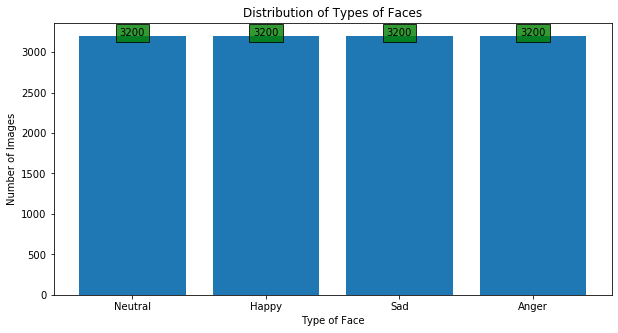

In [21]:
#Printing out the training set
labelCount = []
plt.figure(figsize=(10,5))
for i in range(4):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append((y_train == i).sum())
plt.bar(newTypes, labelCount)
addlabels(newTypes, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

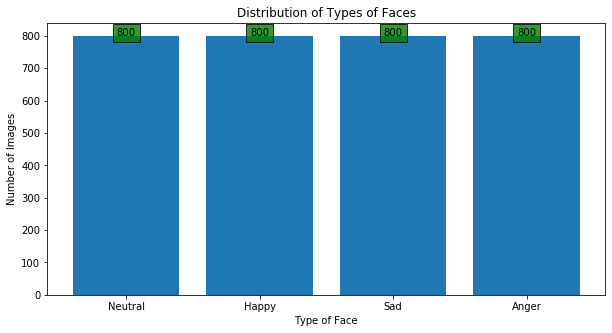

In [22]:
#Printing out the testing set
labelCount = []
plt.figure(figsize=(10,5))
for i in range(4):
    #print("Count of " + types[i] + ": " , labels.count(i))
    labelCount.append((y_test == i).sum())
plt.bar(newTypes, labelCount)
addlabels(newTypes, labelCount)
plt.title("Distribution of Types of Faces")
plt.xlabel('Type of Face')
plt.ylabel('Number of Images')
plt.show()

In [23]:
NUM_CLASSES = 4

# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Running a MLP and base line CNN on the Data Set

In [24]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=1, validation_data = (X_test,y_test_ohe),
       callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/50
400/400 [==============================] - 4s 8ms/step - loss: 1.3420 - accuracy: 0.3455 - val_loss: 1.2453 - val_accuracy: 0.4316
Epoch 2/50
400/400 [==============================] - 3s 9ms/step - loss: 1.1835 - accuracy: 0.4678 - val_loss: 1.1806 - val_accuracy: 0.4663
Epoch 3/50
400/400 [==============================] - 3s 7ms/step - loss: 1.1209 - accuracy: 0.4986 - val_loss: 1.1562 - val_accuracy: 0.4825
Epoch 4/50
400/400 [==============================] - 3s 7ms/step - loss: 1.0684 - accuracy: 0.5377 - val_loss: 1.1761 - val_accuracy: 0.4809
Epoch 5/50
400/400 [==============================] - 3s 6ms/step - loss: 1.0168 - accuracy: 0.5647 - val_loss: 1.2099 - val_accuracy: 0.4831
Wall time: 16.6 s


Epoch 1/15
400/400 [==============================] - 38s 91ms/step - loss: 0.1737 - accuracy: 0.3799 - val_loss: 0.1492 - val_accuracy: 0.5022
Epoch 2/15
400/400 [==============================] - 33s 83ms/step - loss: 0.1432 - accuracy: 0.5443 - val_loss: 0.1458 - val_accuracy: 0.5362
Epoch 3/15
400/400 [==============================] - 34s 85ms/step - loss: 0.1303 - accuracy: 0.6014 - val_loss: 0.1344 - val_accuracy: 0.5853
Epoch 4/15
400/400 [==============================] - 34s 84ms/step - loss: 0.1217 - accuracy: 0.6274 - val_loss: 0.1316 - val_accuracy: 0.5997
Epoch 5/15
400/400 [==============================] - 35s 88ms/step - loss: 0.1107 - accuracy: 0.6770 - val_loss: 0.1326 - val_accuracy: 0.5978
Epoch 6/15
400/400 [==============================] - 36s 90ms/step - loss: 0.1005 - accuracy: 0.7122 - val_loss: 0.1357 - val_accuracy: 0.5825
Wall time: 3min 33s


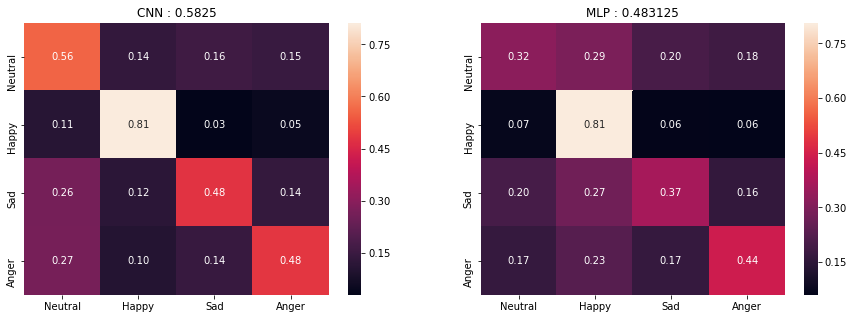

In [25]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_last") )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           data_format="channels_last") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,validation_data=(X_test,y_test_ohe),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

compare_mlp_cnn(cnn1,mlp,X_test,y_test,'CNN', 'MLP', newTypes)

## Data Expansion Technique - Image Data Generator

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage.io import imshow
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

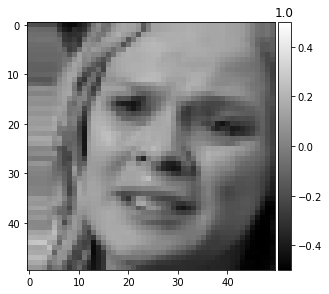

In [27]:
from skimage.io import imshow
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='gray')
    plt.title(labels[np.argmax(tmp[1])])
    break

In [28]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])


    plt.show()


In [29]:
%%time 

img_wh = 50
cnn1 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history1 = cnn1.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                  )
cnn1.save('cnn1_model')



Epoch 1/50
400/400 [==============================] - 148s 367ms/step - loss: 1.3966 - accuracy: 0.3139 - val_loss: 1.2199 - val_accuracy: 0.4669
Epoch 2/50
400/400 [==============================] - 142s 354ms/step - loss: 1.2757 - accuracy: 0.4075 - val_loss: 1.1079 - val_accuracy: 0.5228
Epoch 3/50
400/400 [==============================] - 131s 327ms/step - loss: 1.2051 - accuracy: 0.4450 - val_loss: 1.0842 - val_accuracy: 0.5247
Epoch 4/50
400/400 [==============================] - 101s 251ms/step - loss: 1.1969 - accuracy: 0.4602 - val_loss: 1.0784 - val_accuracy: 0.5178
Epoch 5/50
400/400 [==============================] - 101s 252ms/step - loss: 1.1783 - accuracy: 0.4640 - val_loss: 1.0615 - val_accuracy: 0.5372
Epoch 6/50
400/400 [==============================] - 101s 252ms/step - loss: 1.1599 - accuracy: 0.4818 - val_loss: 1.0646 - val_accuracy: 0.5397
Epoch 7/50
400/400 [==============================] - 100s 250ms/step - loss: 1.1637 - accuracy: 0.4790 - val_loss: 1.0418 -

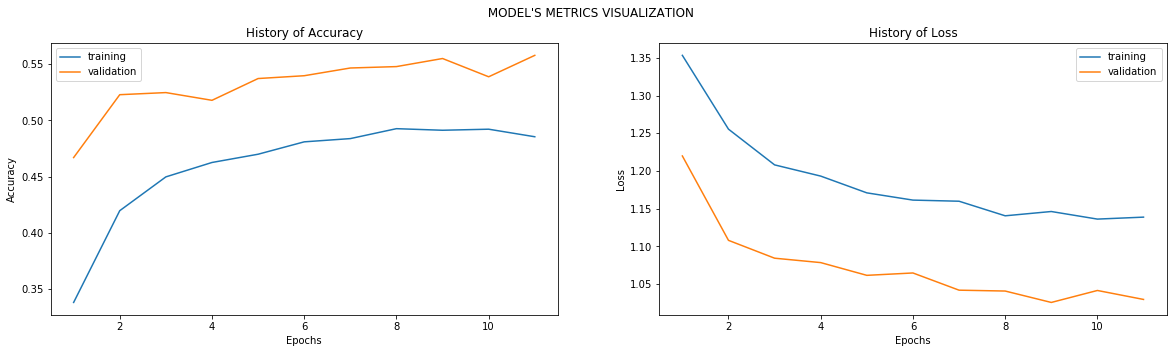

In [30]:
Train_Val_Plot(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
              )


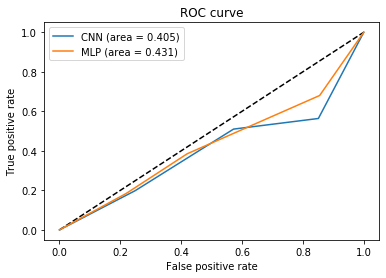

In [31]:
yhat_cnn = np.argmax(cnn1.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [32]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.736396  0.263604
True   0.342857  0.657143


NameError: name 'chi2_contingency' is not defined

In [33]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=82.000, p-value=0.0
Different proportions of errors (reject H0)


Changed the model above in the cell block below. The first max pool now is a 3x3. Following this max pool, we send this through another convolutional layer and max pool (although this is just a 2x2 max pool). Additionally, we increased the batch size from 32 to 64 along with adding in the l2 regularization

In [34]:
from tensorflow.keras.regularizers import l2 
l2_lambda = 0.0001

img_wh = 50
cnn2 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn2.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last"))

cnn2.add(Conv2D(filters=128,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history2 = cnn2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=64), 
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                  )
cnn2.save('cnn2_model')



Epoch 1/50
200/200 [==============================] - 81s 404ms/step - loss: 1.5619 - accuracy: 0.2952 - val_loss: 1.2340 - val_accuracy: 0.4634
Epoch 2/50
200/200 [==============================] - 82s 411ms/step - loss: 1.2995 - accuracy: 0.4075 - val_loss: 1.1175 - val_accuracy: 0.5125
Epoch 3/50
200/200 [==============================] - 89s 443ms/step - loss: 1.1848 - accuracy: 0.4848 - val_loss: 1.0441 - val_accuracy: 0.5562
Epoch 4/50
200/200 [==============================] - 90s 451ms/step - loss: 1.1123 - accuracy: 0.5239 - val_loss: 1.0179 - val_accuracy: 0.5628
Epoch 5/50
200/200 [==============================] - 91s 457ms/step - loss: 1.0773 - accuracy: 0.5440 - val_loss: 0.9871 - val_accuracy: 0.5791
Epoch 6/50
200/200 [==============================] - 91s 453ms/step - loss: 1.0561 - accuracy: 0.5570 - val_loss: 0.9656 - val_accuracy: 0.5913
Epoch 7/50
200/200 [==============================] - 91s 453ms/step - loss: 1.0109 - accuracy: 0.5779 - val_loss: 0.9589 - val_ac

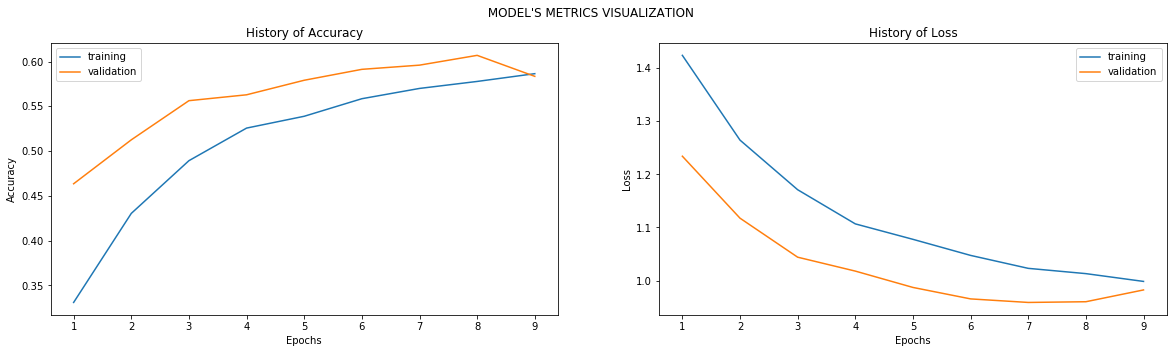

In [36]:
Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss']
              )

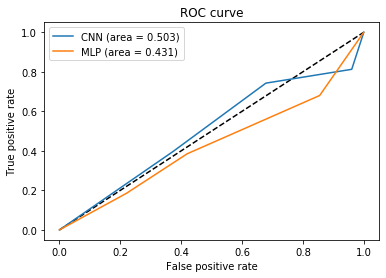

In [37]:
yhat_cnn = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [38]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=29.000, p-value=0.0
Different proportions of errors (reject H0)


Now let's compare the first cnn to this new cnn below

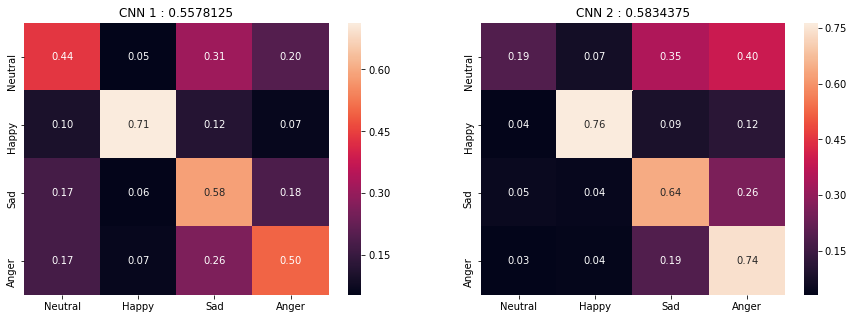

In [39]:
compare_mlp_cnn(cnn1,cnn2,X_test,y_test,'CNN 1', 'CNN 2',newTypes)

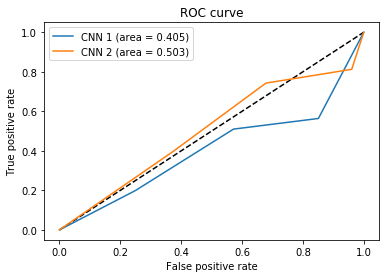

In [40]:
yhat_cnn = np.argmax(cnn1.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN 1 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [41]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=82.000, p-value=0.0
Different proportions of errors (reject H0)


Now change the max pools to 2x2, add in another convolutional layer, back to 32 batch size, and taking away some of the dropout

In [42]:
from tensorflow.keras.regularizers import l2
l2_lambda = 0.0001
cnn4 = Sequential()
cnn4.add( Conv2D(filters=32,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
# cnn.add( MaxPooling2D(pool_size=(2, 2),
#                 data_format="channels_last") )
cnn4.add( Conv2D(filters=32,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
cnn4.add( MaxPooling2D(pool_size=(2, 2),
                data_format="channels_last") )
cnn4.add( Conv2D(filters=64,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
# cnn.add( MaxPooling2D(pool_size=(2, 2),
#                 data_format="channels_last") )
cnn4.add( Conv2D(filters=64,
                kernel_size= (3, 3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                input_shape=(img_wh, img_wh, 1),
                activation='relu',
                data_format="channels_last") )
cnn4.add( MaxPooling2D(pool_size=(2, 2),
                data_format="channels_last") )
cnn4.add(Conv2D(filters=128,
               input_shape=(img_wh, img_wh, 1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform',
               kernel_regularizer=l2(l2_lambda),
               padding='same',
               activation='relu',data_format="channels_last")) # more compact syntax
cnn4.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform',
               kernel_regularizer=l2(l2_lambda),
               padding='same',
               activation='relu',data_format="channels_last"))
# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add(Dropout(0.25))
cnn4.add(Dense(128,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda) ))
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

cnn4.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
# the flow method yields batches of images indefinitely, with the given transformations
history_cnn4 = cnn4.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32),
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=50, verbose=1,
                   validation_data=(X_test,y_test_ohe),
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

cnn4.save('cnn4_model')


Epoch 1/50
400/400 [==============================] - 127s 316ms/step - loss: 1.6262 - accuracy: 0.3144 - val_loss: 1.1303 - val_accuracy: 0.5244
Epoch 2/50
400/400 [==============================] - 130s 324ms/step - loss: 1.1664 - accuracy: 0.5027 - val_loss: 1.0344 - val_accuracy: 0.5763
Epoch 3/50
400/400 [==============================] - 142s 354ms/step - loss: 1.0875 - accuracy: 0.5419 - val_loss: 1.0052 - val_accuracy: 0.5934
Epoch 4/50
400/400 [==============================] - 142s 355ms/step - loss: 1.0499 - accuracy: 0.5719 - val_loss: 0.9882 - val_accuracy: 0.6059
Epoch 5/50
400/400 [==============================] - 141s 352ms/step - loss: 1.0227 - accuracy: 0.5893 - val_loss: 0.9464 - val_accuracy: 0.6153
Epoch 6/50
400/400 [==============================] - 139s 347ms/step - loss: 0.9787 - accuracy: 0.6176 - val_loss: 0.9643 - val_accuracy: 0.6281
Epoch 7/50
400/400 [==============================] - 144s 360ms/step - loss: 0.9816 - accuracy: 0.6094 - val_loss: 0.9393 -

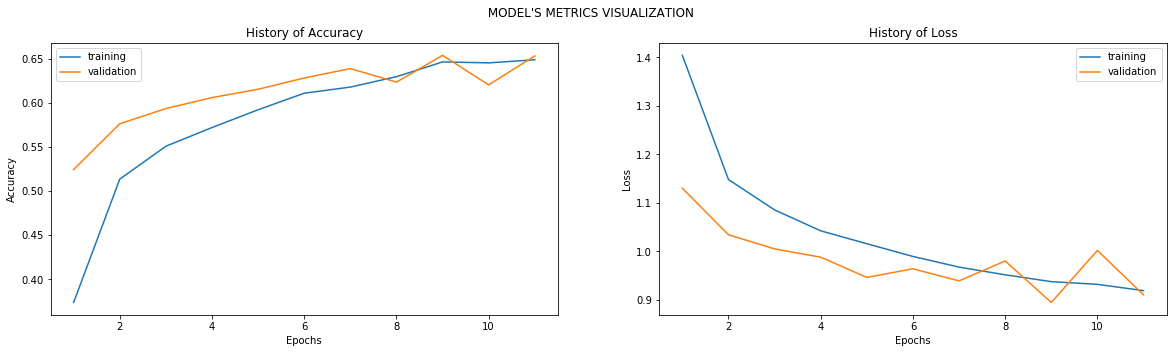

In [43]:
Train_Val_Plot(history_cnn4.history['accuracy'],history_cnn4.history['val_accuracy'],
               history_cnn4.history['loss'],history_cnn4.history['val_loss'],
              )

Compare to MLP

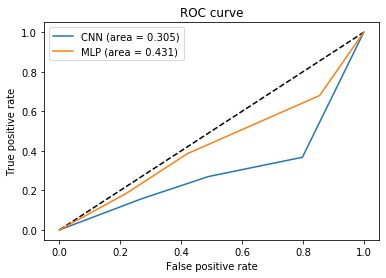

In [44]:
yhat_cnn = np.argmax(cnn4.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [45]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=88.000, p-value=0.0
Different proportions of errors (reject H0)


Compare this one to the previous best CNN of similar architecture

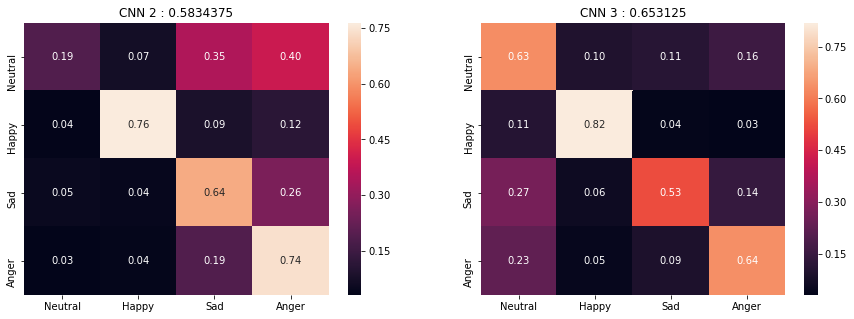

In [46]:
compare_mlp_cnn(cnn2,cnn4,X_test,y_test,'CNN 2', 'CNN 3', newTypes)

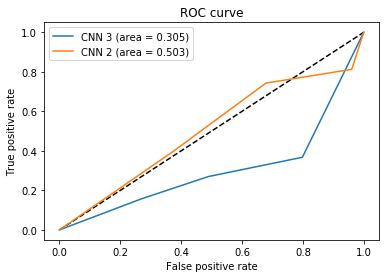

In [47]:
yhat_cnn = np.argmax(cnn4.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn2.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN 3 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 2 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [48]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

statistic=88.000, p-value=0.0
Different proportions of errors (reject H0)


Now let's use Xception model

In [49]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)
xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

historyXcept = xception.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )
xception.save('xception_model')


Epoch 1/50
400/400 [==============================] - 35s 85ms/step - loss: 1.4029 - accuracy: 0.2959 - val_loss: 1.2270 - val_accuracy: 0.4416
Epoch 2/50
400/400 [==============================] - 34s 85ms/step - loss: 1.3058 - accuracy: 0.3902 - val_loss: 1.1790 - val_accuracy: 0.4847
Epoch 3/50
400/400 [==============================] - 35s 87ms/step - loss: 1.2478 - accuracy: 0.4222 - val_loss: 1.0966 - val_accuracy: 0.5300
Epoch 4/50
400/400 [==============================] - 34s 85ms/step - loss: 1.1938 - accuracy: 0.4512 - val_loss: 1.0607 - val_accuracy: 0.5466
Epoch 5/50
400/400 [==============================] - 34s 85ms/step - loss: 1.1620 - accuracy: 0.4804 - val_loss: 1.0403 - val_accuracy: 0.5341
Epoch 6/50
400/400 [==============================] - 34s 85ms/step - loss: 1.1284 - accuracy: 0.4990 - val_loss: 1.0245 - val_accuracy: 0.5525
Epoch 7/50
400/400 [==============================] - 34s 86ms/step - loss: 1.0997 - accuracy: 0.5140 - val_loss: 1.0012 - val_accuracy:

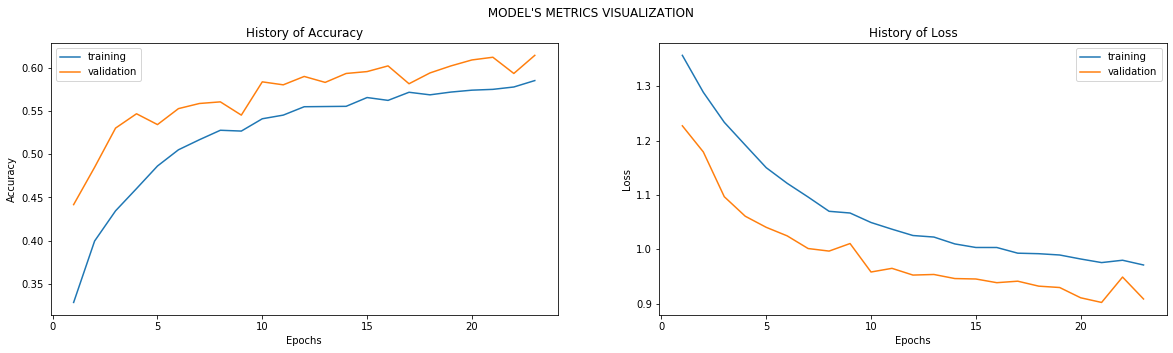

In [50]:
Train_Val_Plot(historyXcept.history['accuracy'],historyXcept.history['val_accuracy'],
               historyXcept.history['loss'],historyXcept.history['val_loss'],
              )

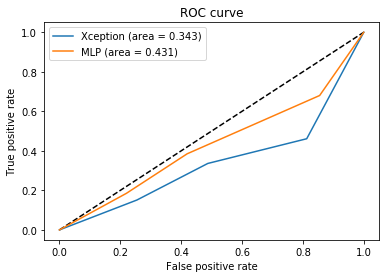

In [51]:
yhat_cnn = np.argmax(xception.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [52]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.745749  0.254251
True   0.373028  0.626972


NameError: name 'chi2_contingency' is not defined

In [ ]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

Switching some stuff up from the Xception model above. Added in 3 convolutional layers, a max pooling, and batch size up to 64. Additionally, decreased the dropout in both dropout percentages by 20%

In [ ]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

#Changes

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception2 = Model(inputs=input_holder,outputs=x)
xception2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

historyXcept2 = xception2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=64), 
                      steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )

xception2.save('xception2_model')

In [ ]:
Train_Val_Plot(historyXcept2.history['accuracy'],historyXcept2.history['val_accuracy'],
               historyXcept2.history['loss'],historyXcept2.history['val_loss'],
              )

In [ ]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(mlp.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [ ]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

Now, let's compare the 2 Xception models to each other

In [ ]:
compare_mlp_cnn(xception,xception2,X_test,y_test,'Xception', 'Xception 2', newTypes)

In [ ]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(xception.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Xception 1 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [ ]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

Now, let's compare the best Xception model to the best model of the first CNN styled architecture

In [ ]:
compare_mlp_cnn(cnn4,xception2,X_test,y_test,'CNN 3', 'Xception 2',newTypes)

In [ ]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(cnn4.predict_generator(X_test), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='CNN 3 (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [ ]:
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected = chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

In [ ]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar

cm_mlp = mt.confusion_matrix(y_test, yhat_mlp, labels=[0,1])
cm_cnn = mt.confusion_matrix(y_test, yhat_cnn, labels=[0,1])
# define contingency table
table = [[cm_cnn[1][1], cm_cnn[1][0]],[cm_mlp[1][1], cm_mlp[1][0]]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

## Ensemble Net - Attempted, but didn't work

Attempted to use ensemble net, but we were getting 25% val accuracy every epoch and couldn't figure out why it didn't change at all

In [ ]:
## Ensemble Net

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)
#ADD MAX POOL LAYER HERE
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)


In [ ]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [ ]:
%%time
# the flow method yields batches of images indefinitely, with the given transofmrations
history3 = cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                     )

Changing the Ensemble Net. After concatenating the branches, going to add some drop out and a dense layer before sending it throught the final dense layer. Also, increased the number of branches from 3 to 4

In [ ]:
## Ensemble Net

%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 4
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)
#ADD MAX POOL LAYER HERE
x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

#Changes Here

x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
x = Dense(64, 
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda)
            )(x)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens2 = Model(inputs=input_holder,outputs=x)


In [ ]:
# Let's train the model 
cnn_ens2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [ ]:
%%time
# the flow method yields batches of images indefinitely, with the given transofmrations
history4 = cnn_ens2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                      steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

In [ ]:
compare_mlp_cnn(cnn_ens,cnn_ens2,X_test,y_test,newTypes, 'CNN Ensemble 1', 'CNN Ensemble 2')

## Exceptional Work

Transfer Learning with ResNet50!!

First, we ohe our y data. <br></br>
Second, we get the resnet50 base model that will serve as a majority of our NN.<br></br>
Third, we preprocess the input and use the base modelto run a .predict on the image data.<br></br>
Then, we create our model with the desired layers and fit the model to the preprocessed data.


In [ ]:
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model

In [ ]:
y_train_ohe_c = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_c = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

In [ ]:
# load only convolutional layers of resnet:
if 'base_model' not in locals():
    base_model = ResNet50(weights='imagenet', include_top=False)
    
x_test_up = preprocess_input(X_test_color)
x_train_up = preprocess_input(X_train_color)


In [ ]:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)
    
x_test_up = np.stack(X_test_color, axis=0)
x_train_up = np.stack(X_train_color, axis=0)
#x_test_up = np.expand_dims(x_test_up, axis=0)
#x_train_up = np.expand_dims(x_train_up, axis=0)
x_test_up = preprocess_input(x_test_up)
x_train_up = preprocess_input(x_train_up)


In [ ]:
x_train_resnet = res_no_top.predict(x_train_up)
#x_test_resnet = res_no_top.predict(x_test_up)

In [ ]:
blank

In [ ]:
x_train_resnet = base_model.predict(x_train_up)
x_test_resnet = base_model.predict(x_test_up)

In [ ]:
x_train_resnet

In [ ]:
y_train_ohe_resnet = y_train_ohe_c[:x_train_resnet.shape[0]]
# y_test_ohe_resnet = y_test_ohe_c[:x_test_resnet.shape[0]]
# print(x_train_resnet.shape)
# print(x_test_resnet.shape)
# print(y_train_ohe_resnet.shape)
# print(y_test_ohe_resnet.shape)

In [ ]:
np.unique(y_train_ohe_resnet)

In [ ]:
# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()


In [ ]:
yhat_cnn = np.argmax(xception2.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(model.predict_generator(X_test_color), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_color, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Transfer Learning (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


After hours of trying to make transfer learning work, we could not get our model to train on our data. We followed online guides and classwork directly but were not able to figure out why with transfer learning the NN will not actually train. It always prints out that the accuracy and validation accuracy are 75% even though the true validation accuracy is far lower. See the Confusion matrix below if this description is not clear. We even tried doing the same process with xception to no avail.


## Execeptional Work II

In [54]:
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model

In [56]:
y_train_ohe_c = keras.utils.to_categorical(y_train_color, NUM_CLASSES)
y_test_ohe_c = keras.utils.to_categorical(y_test_color, NUM_CLASSES)

In [59]:
%%time
# from skimage.transform import resize # stupid slow function
#from scipy.misc import imresize
import numpy as np

# CIFAR is really small, so let's increase the size of it so its not so small
# once we put it through all the downsampling layers
#x_train_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_train]
x_train_up = np.stack(X_train_color, axis=0)
print(x_train_up.shape)

#x_test_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_test]
x_test_up = np.stack(X_test_color, axis=0)
print(x_test_up.shape)

(12800, 50, 50, 3)
(3200, 50, 50, 3)
Wall time: 2.79 s


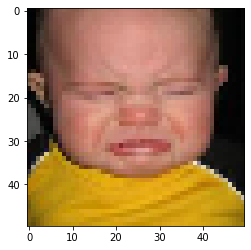

In [61]:
idx = 5
plt.imshow((X_train_color[idx]-X_train_color[idx].min())/(X_train_color[idx].max()-X_train_color[idx].min()))
plt.grid(False)

In [62]:
x_train_up[0].max()

-103.95664705882352

In [63]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

Wall time: 57 ms


(1, 2, 2, 2048)

In [64]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [65]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(12800, 2, 2, 2048)
Wall time: 2min 50s


In [66]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2, 2, 2048)]      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               1638600   
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 804       
Total params: 1,639,404
Trainable params: 1,639,404
Non-trainable params: 0
_________________________________________________________________


In [67]:
y_train_ohe_resnet = y_train_ohe_c[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]))

Epoch 1/5
200/200 [==============================] - 7s 33ms/step - loss: 2.3971 - accuracy: 0.2588 - val_loss: 1.3846 - val_accuracy: 0.2887
Epoch 2/5
200/200 [==============================] - 7s 34ms/step - loss: 1.3845 - accuracy: 0.2748 - val_loss: 1.3835 - val_accuracy: 0.2697
Epoch 3/5
200/200 [==============================] - 6s 32ms/step - loss: 1.3810 - accuracy: 0.2777 - val_loss: 1.4901 - val_accuracy: 0.2500
Epoch 4/5
200/200 [==============================] - 6s 32ms/step - loss: 1.3823 - accuracy: 0.2839 - val_loss: 1.3788 - val_accuracy: 0.2794
Epoch 5/5
200/200 [==============================] - 6s 32ms/step - loss: 1.3760 - accuracy: 0.2789 - val_loss: 1.3843 - val_accuracy: 0.2709


In [68]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]))

Epoch 1/5
200/200 [==============================] - 7s 34ms/step - loss: 1.3718 - accuracy: 0.2944 - val_loss: 1.3763 - val_accuracy: 0.2850
Epoch 2/5
200/200 [==============================] - 7s 35ms/step - loss: 1.3711 - accuracy: 0.2986 - val_loss: 1.3692 - val_accuracy: 0.3028
Epoch 3/5
200/200 [==============================] - 7s 36ms/step - loss: 1.3677 - accuracy: 0.3020 - val_loss: 1.3757 - val_accuracy: 0.2903
Epoch 4/5
200/200 [==============================] - 7s 36ms/step - loss: 1.3660 - accuracy: 0.3130 - val_loss: 1.3702 - val_accuracy: 0.2994
Epoch 5/5
200/200 [==============================] - 7s 36ms/step - loss: 1.3627 - accuracy: 0.3113 - val_loss: 1.3747 - val_accuracy: 0.2950


In [69]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=10,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe_c[:x_test_resnet.shape[0]]))

Epoch 1/10
200/200 [==============================] - 8s 38ms/step - loss: 1.3604 - accuracy: 0.3199 - val_loss: 1.3694 - val_accuracy: 0.3059
Epoch 2/10
200/200 [==============================] - 7s 36ms/step - loss: 1.3585 - accuracy: 0.3196 - val_loss: 1.3569 - val_accuracy: 0.3225
Epoch 3/10
200/200 [==============================] - 6s 31ms/step - loss: 1.3562 - accuracy: 0.3260 - val_loss: 1.3754 - val_accuracy: 0.2919
Epoch 4/10
200/200 [==============================] - 6s 28ms/step - loss: 1.3539 - accuracy: 0.3234 - val_loss: 1.3748 - val_accuracy: 0.2966
Epoch 5/10
200/200 [==============================] - 6s 31ms/step - loss: 1.3531 - accuracy: 0.3255 - val_loss: 1.3671 - val_accuracy: 0.3103
Epoch 6/10
200/200 [==============================] - 6s 28ms/step - loss: 1.3501 - accuracy: 0.3304 - val_loss: 1.3476 - val_accuracy: 0.3356
Epoch 7/10
200/200 [==============================] - 6s 28ms/step - loss: 1.3481 - accuracy: 0.3353 - val_loss: 1.3469 - val_accuracy: 0.3266

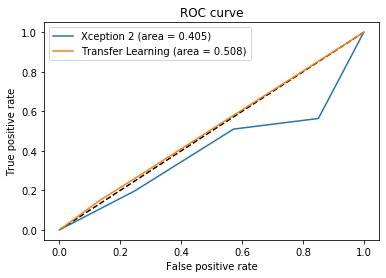

In [72]:
yhat_cnn = np.argmax(cnn1.predict_generator(X_test), axis=1).ravel()
yhat_mlp = np.argmax(model.predict_generator(x_test_resnet), axis=1).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, yhat_cnn, pos_label=0)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_color, yhat_mlp, pos_label=0)

auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='Xception 2 (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_mlp, tpr_mlp, label='Transfer Learning (area = {:.3f})'.format(auc_mlp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


In [81]:
import scipy
from scipy.stats import chisquare
yhat_cnn_acc = yhat_cnn == y_test
yhat_mlp_acc = yhat_mlp == y_test
contigency= pd.crosstab(yhat_cnn_acc, yhat_mlp_acc, normalize='index')
print(contigency)
c, p, dof, expected =  scipy.stats.chi2_contingency(contigency)
# summarize the finding
print('statistic=%.3f, p-value=%.1f' % (c, p))
# interpret the p-value
alpha = 0.05
if p > alpha:
    print("Same proportions of errors (don't reject H0)")
else:
    print('Different proportions of errors (reject H0)')

col_0     False     True 
row_0                    
False  0.814841  0.185159
True   0.580952  0.419048
statistic=1.392, p-value=0.2
Same proportions of errors (don't reject H0)
